In [9]:
##Azureセットアップ

import configparser

config = configparser.ConfigParser()
config.read('../config.ini')
key = config['setting']['ACCOUNT_KEY']
endpoint = config['setting']['END_POINT']

##OCR関数

from img2table.document import Image
from img2table.ocr import AzureOCR
import cv2
from PIL import Image as PILImage

import os

##PWD = os.getcwd()
PWD = '/Users/satoki252595/work/20240114_nriocr2'

PATH_IMAGE = PWD + '/static/image/'
PATH_IMAGE = PWD + '/static/image/'
PATH_TEXT = PWD + '/static/text/'

def getImageTable_Azuru(img_path,lessFlag= False):
    
    # Instantiation of OCR
    ocr = AzureOCR(endpoint=endpoint,subscription_key=key)

    # Instantiation of document, either an image or a PDF
    doc = Image(src = img_path)

    
    # 見えない線を加味オプション設定。
    implicit_rows = False
    borderless_tables = False
    if lessFlag == True:
        implicit_rows = True
        borderless_tables = True
        

    # Table extraction
    extracted_tables = doc.extract_tables(ocr=ocr,
                                        implicit_rows=implicit_rows,
                                        borderless_tables=borderless_tables,
                                        min_confidence=50)
    
    return extracted_tables

def visualTable(extracted_tables,imageFileName,BA_Flag='mae'):

    if BA_Flag == 'mae':
        
        # Display extracted tables
        table_img = cv2.imread(PATH_IMAGE +'mae/'+imageFileName)

    if BA_Flag == 'ato':
        # Display extracted tables
        table_img = cv2.imread(PATH_IMAGE +'ato/'+imageFileName)
        

    for table in extracted_tables:
        for row in table.content.values():
            for cell in row:
                cv2.rectangle(table_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)
                
    return PILImage.fromarray(table_img)

FileName = '4307.png'
    
t_mae = extracted_tables = getImageTable_Azuru(PATH_IMAGE + 'mae/'+ FileName,lessFlag = False)
t_ato = extracted_tables = getImageTable_Azuru(PATH_IMAGE + 'ato/'+ FileName,lessFlag = False)
vt_mae_image = visualTable(t_mae,FileName,BA_Flag='mae')
vt_ato_image = visualTable(t_ato,FileName,BA_Flag='ato')

In [10]:
## OCRのAPIによって、空白があったり無かったりするので、これを解決するために空白や改行コード削除処理を行う。
## ★制約として、現新比較する場合に空白を検知できないので、そこを見分ける必要がある。　
## 改行コードは削除しなくても良かったかも。

## ★制約として、表のフッダー部分は差分を検知できない。

t_mae_cleansing = []

for t_mae_ExtractedTable in t_mae:
    if t_mae_ExtractedTable.title != None:
        title = t_mae_ExtractedTable.title.replace('\n','')
        title = title.replace(' ','')
        title = title.replace('　','')
    else:
        title = ''
    df = t_mae_ExtractedTable.df.fillna('')
    df = df.replace('\n','',regex=True)
    df = df.replace(' ','',regex=True)
    df = df.replace('　','',regex=True)
    t_mae_cleansing.append([title,df])

t_ato_cleansing = []

for t_ato_ExtractedTable in t_ato:
    if t_ato_ExtractedTable.title != None:
        title = t_ato_ExtractedTable.title.replace('\n','')
        title = title.replace(' ','')
        title = title.replace('　','')
    else:
        title = ''
    df = t_ato_ExtractedTable.df.fillna('')
    df = df.replace('\n','',regex=True).fillna('')
    df = df.replace(' ','',regex=True)
    df = df.replace('　','',regex=True)
    t_ato_cleansing.append([title,df])


In [11]:
##クレンジング前

df_mae = t_mae[0].df
df_ato = t_ato[0].df


df_diff = df_mae==df_ato
df_diff

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,False,True,True,False,False,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
##クレンジング後

df_diff = t_mae_cleansing[0][1]==t_ato_cleansing[0][1]
df_diff

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,True,True,True,False,False,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False


In [20]:
t_mae_cleansing[0][1]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,,売上収益,売上収益,営業利,営業利,税引前利益,税引前利益,当期利益,当期利益,親会社の所有者に帰属する当期利益,親会社の所有者に帰属する当期利益,当期包括利益合計額,当期包括利益合計額
1,2022年3月期2021年3月期,"百万円611.634550,337",9%11.11.1,"百円106.21880,748",9631.5△5.7,百万円104.67171.075,47.3416.9,"百万円71,79252,578",9636.5△11.0,"百万円71,44552,867",9635.149.2,"百万円83,58081,882",2.171.


In [21]:
t_ato_cleansing[0][1]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,,売上収益,売上収益,営業利益,営業利益,税引前利益,税引前利益,当期利益,当期利益,親会社の所有者に帰属する当期利益,親会社の所有者に帰属する当期利益,当期包括利益合計額,当期包括利益合計額
1,2023年3月期2022年3月期,"百万円692,165611,634",%13.211.1,"百万円111,832106,218",%5.331.5,"百万円108,499104,671",%3.747.3,"百万円76,49671,792",%6.636.5,"百万円76,30771,445",%6.835.1,"百万円80,78283,580",%△3.32.1


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,None,売 上 収 益,売 上 収 益,営 業 利,営 業 利,税 引 前 利 益,税 引 前 利 益,当 期 利 益,当 期 利 益,親 会 社 の 所 有 者 に\n帰 属 す る 当 期 利 益,親 会 社 の 所 有 者 に\n帰 属 す る 当 期 利 益,当 期 包 括 利 益\n合 計 額,当 期 包 括 利 益\n合 計 額
1,2022 年 3 月 期\n2021 年 3 月 期,"百 万 円\n611. 634\n550, 337",9%\n11.1\n1.1,"百 円\n106. 218\n80, 748",96\n31.5\n△5. 7,百 万 円\n104. 671\n71.075,47. 3\n416.9,"百 万 円\n71, 792\n52, 578",96\n36.5\n△11.0,"百 万 円\n71,445\n52,867",96\n35.1\n49.2,"百 万 円\n83, 580\n81, 882",2.1\n71.


In [13]:
import pandas

def check_true(target):
    
    if isinstance(target,bool):
        return 'title',target
    if isinstance(target,pandas.core.frame.DataFrame):
        x = True
        for b in target.all():
            x *= b
        return 'table',bool(x)

In [14]:
##全行列の比較

for idx,(mae,ato) in enumerate(zip(t_mae_cleansing,t_ato_cleansing)):
    for jdx,(m,a) in enumerate(zip(mae,ato)):
        diff = m == a
        info,result = check_true(diff)            
        print('({},{})　{}：{}'.format(idx,jdx,info,result))

(0,0)　title：False
(0,1)　table：False
(1,0)　title：True
(1,1)　table：False
(2,0)　title：False
(2,1)　table：False
(3,0)　title：True
(3,1)　table：False


In [25]:
##全行列の比較を行い、差分がある箇所にマークをつける処理

mae_img = cv2.imread(PATH_IMAGE +'mae/'+FileName)
ato_img = cv2.imread(PATH_IMAGE +'ato/'+FileName)

for idx,(mae,ato) in enumerate(zip(t_mae_cleansing,t_ato_cleansing)):
    for jdx,(m,a) in enumerate(zip(mae,ato)):
        diff = m == a
        info,result = check_true(diff)

        print('({},{})　{}：{}'.format(idx,jdx,info,result))

        ##ここで差分がある場合はImageに赤線などをつける処理を入れる。
        if result == False:

            ##タイトルに差分がある箇所を描画
            if info == 'title':
                cv2.line(mae_img,(t_mae[idx].bbox.x1, t_mae[idx].bbox.y1), (t_mae[idx].bbox.x2, t_mae[idx].bbox.y1), (0, 255, 255), thickness=5, lineType=cv2.LINE_AA)
                cv2.line(ato_img,(t_ato[idx].bbox.x1, t_ato[idx].bbox.y1), (t_ato[idx].bbox.x2, t_ato[idx].bbox.y1), (0, 255, 255), thickness=5, lineType=cv2.LINE_AA)

            #セル（表）に差分がある箇所を描画
            else:
                for i in range(diff.shape[0]):
                    for j in range(diff.shape[1]):
                        if diff.iloc[i,j] == False:
                            for ii,row in enumerate(t_mae[idx].content.values()):
                                for jj,cell in enumerate(row):
                                    if i==ii and j==jj:
                                        cv2.rectangle(mae_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)
                            for ii,row in enumerate(t_ato[idx].content.values()):
                                for jj,cell in enumerate(row):
                                    if i==ii and j==jj:
                                        cv2.rectangle(ato_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)

##そもそも表対象外の部分を表示

if len(t_ato) - len(t_mae) < 0:
    for i,mae in enumerate(t_mae):
        if i > len(t_ato) -1:
            cv2.rectangle(mae_img, (mae.bbox.x1, mae.bbox.y1), (mae.bbox.x2, mae.bbox.y2), (255, 0, 0), 2)
elif len(t_ato) - len(t_mae) > 0:
    for i,ato in enumerate(t_ato):
        if i > len(t_mae) -1:
            cv2.rectangle(ato_img, (ato.bbox.x1, ato.bbox.y1), (ato.bbox.x2, ato.bbox.y2), (255, 0, 0), 2)

(0,0)　title：False
(0,1)　table：False
(1,0)　title：True
(1,1)　table：False
(2,0)　title：False
(2,1)　table：False
(3,0)　title：True
(3,1)　table：False


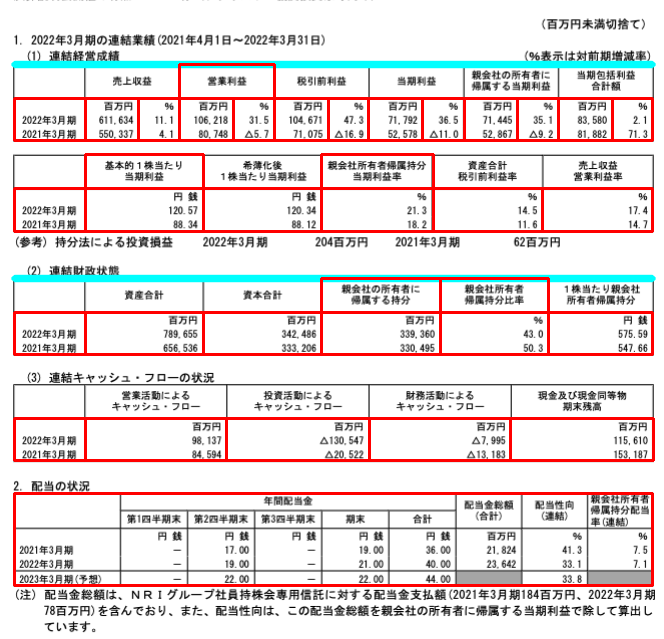

In [24]:
PILImage.fromarray(mae_img)


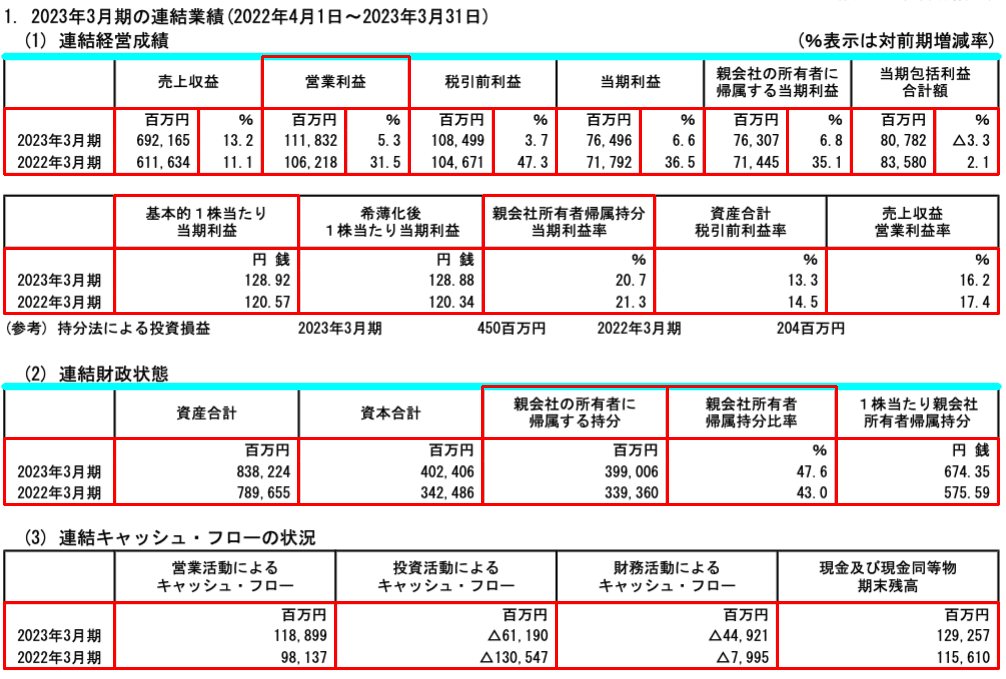

In [17]:
PILImage.fromarray(ato_img)


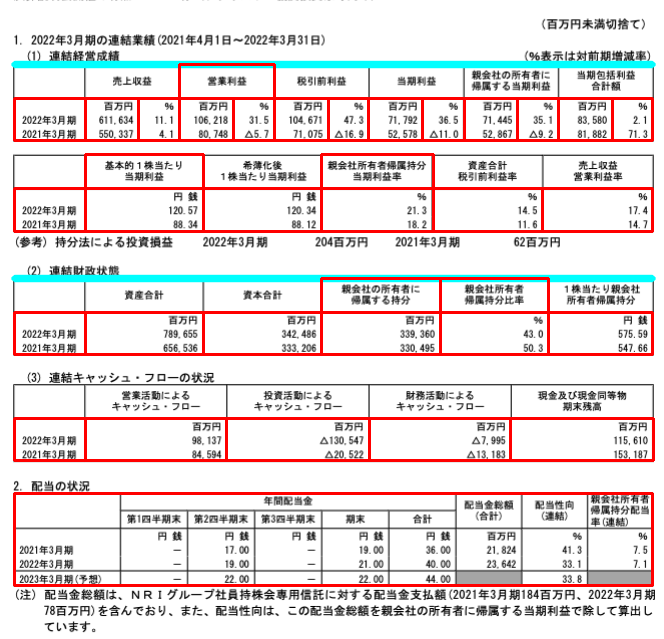

In [19]:
PILImage.fromarray(mae_img)

In [109]:
mae_img = cv2.imread(PATH_IMAGE +'mae/'+FileName)
ato_img = cv2.imread(PATH_IMAGE +'ato/'+FileName)

In [110]:
diff

,0,1,2,3,4
0,True,True,True,True,True
1,True,True,False,True,True


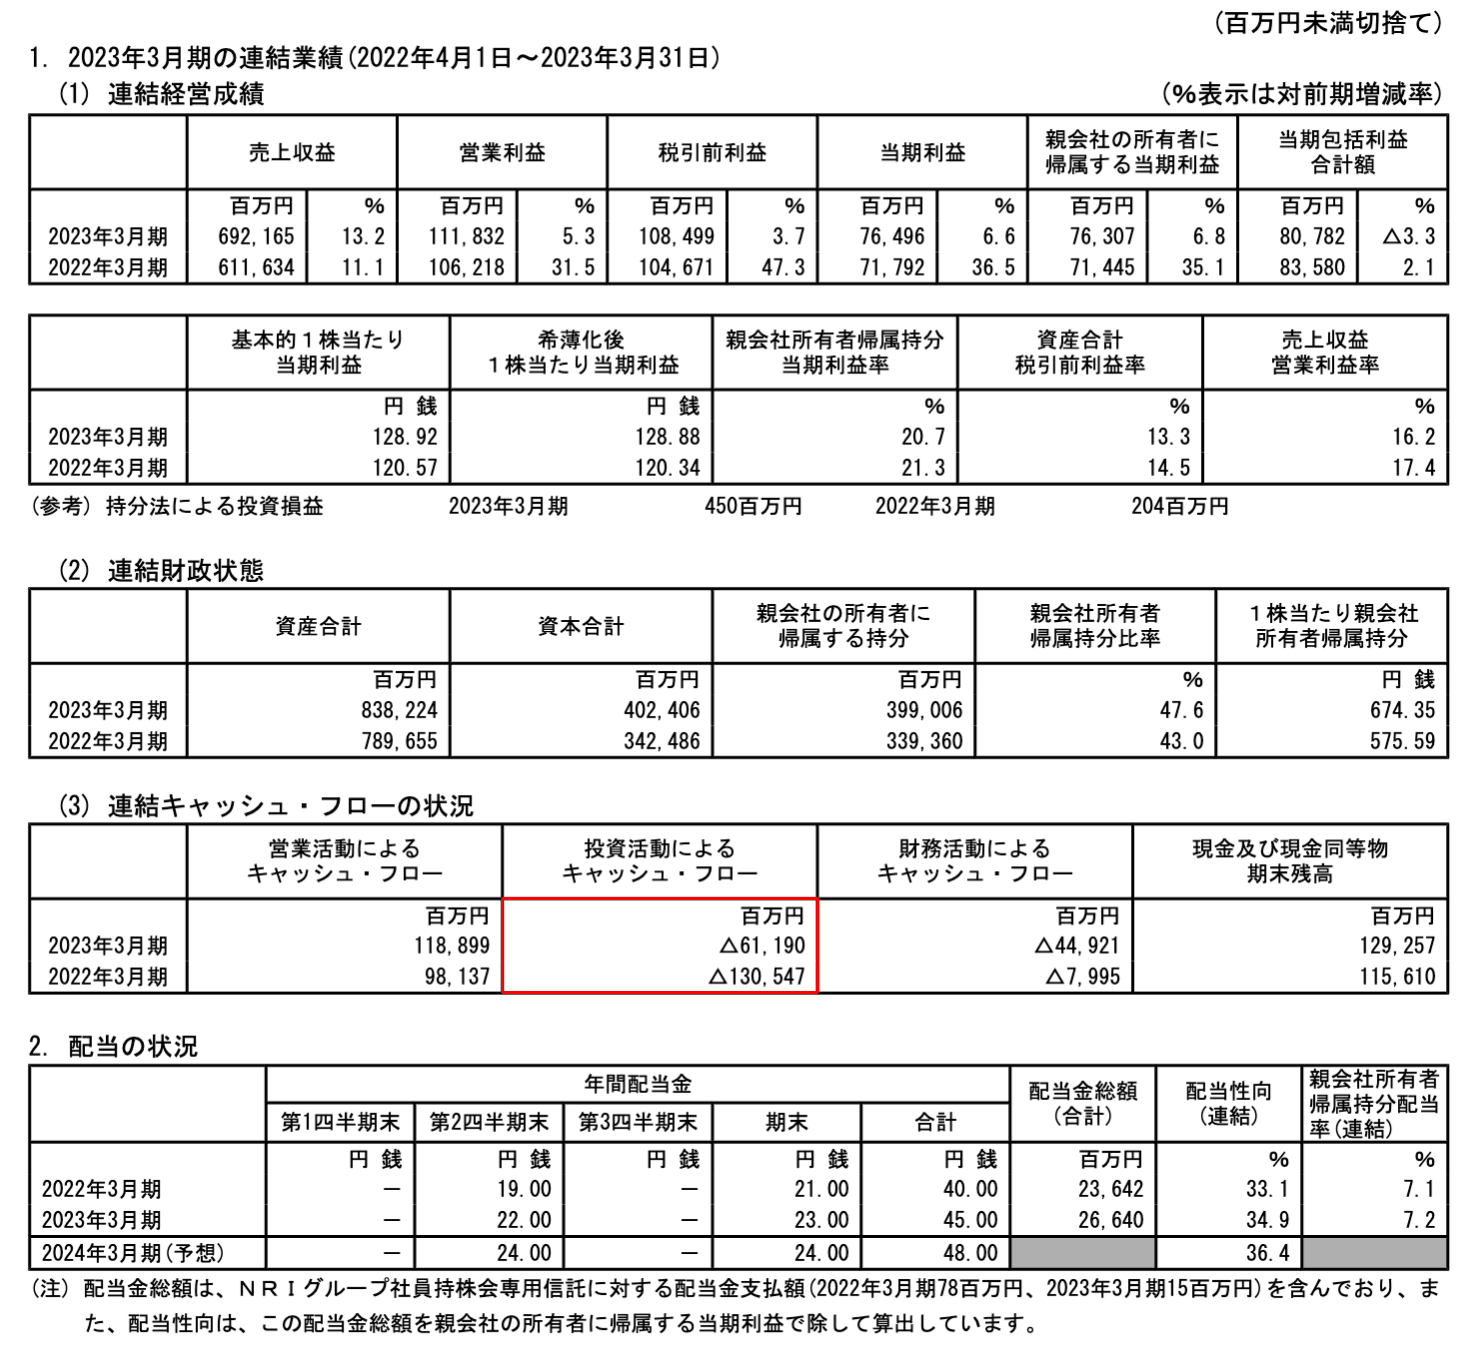

In [112]:
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff.iloc[i,j] == False:
            for ii,row in enumerate(t_mae[3].content.values()):
                for jj,cell in enumerate(row):
                    if i==ii and j==jj:
                        cv2.rectangle(mae_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)

PILImage.fromarray(mae_img)

In [115]:
obj = t_mae[3].content.values()
obj

odict_values([[TableCell(bbox=BBox(x1=29, y1=824, x2=186, y2=898), value=None), TableCell(bbox=BBox(x1=186, y1=824, x2=502, y2=898), value='営 業 活 動 に よ る\nキ ャ ッ シ ュ · フ ロ ー'), TableCell(bbox=BBox(x1=502, y1=824, x2=817, y2=898), value='投 資 活 動 に よ る\nキ ャ ッ シ ュ · フ ロ ー'), TableCell(bbox=BBox(x1=817, y1=824, x2=1132, y2=898), value='財 務 活 動 に よ る\nキ ャ ッ シ ュ · フ ロ ー'), TableCell(bbox=BBox(x1=1132, y1=824, x2=1448, y2=898), value='現 金 及 び 現 金 同 等 物\n期 末 残 高')], [TableCell(bbox=BBox(x1=29, y1=898, x2=186, y2=992), value='2023 年 3 月 期\n2022 年 3 月 期'), TableCell(bbox=BBox(x1=186, y1=898, x2=502, y2=992), value='百 万 円\n118, 899\n98, 137'), TableCell(bbox=BBox(x1=502, y1=898, x2=817, y2=992), value='百 万 円\n△61, 190\n△130, 547'), TableCell(bbox=BBox(x1=817, y1=898, x2=1132, y2=992), value='百 万 円\n△44, 921\n△7,995'), TableCell(bbox=BBox(x1=1132, y1=898, x2=1448, y2=992), value='百 万 円\n129,257\n115,610')]])

In [ ]:
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff.iloc[i,j] == False:
            for ii,row in enumerate(t_mae[3].content.values()):
                for jj,cell in enumerate(row):
                    if i==ii and j==jj:
                        cv2.rectangle(mae_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)

PILImage.fromarray(mae_img)

In [150]:
##全行列の比較を行い、差分がある箇所にマークをつける処理

mae_img = cv2.imread(PATH_IMAGE +'mae/'+FileName)
ato_img = cv2.imread(PATH_IMAGE +'ato/'+FileName)

def diff_draw(t_mae_cleansing,t_ato_cleansing,mae_img,ato_img):

    for idx,(mae,ato) in enumerate(zip(t_mae_cleansing,t_ato_cleansing)):
        for jdx,(m,a) in enumerate(zip(mae,ato)):
            diff = m == a
            info,result = check_true(diff)
    
            ##ここで差分がある場合はImageに赤線などをつける処理を入れる。
            if result == False:
    
                ##タイトルに差分がある箇所を描画
                if info == 'title':
                    cv2.line(mae_img,(t_mae[idx].bbox.x1, t_mae[idx].bbox.y1), (t_mae[idx].bbox.x2, t_mae[idx].bbox.y1), (0, 255, 255), thickness=5, lineType=cv2.LINE_AA)
                    cv2.line(ato_img,(t_ato[idx].bbox.x1, t_ato[idx].bbox.y1), (t_ato[idx].bbox.x2, t_ato[idx].bbox.y1), (0, 255, 255), thickness=5, lineType=cv2.LINE_AA)
    
                #セル（表）に差分がある箇所を描画
                else:
                    for i in range(diff.shape[0]):
                        for j in range(diff.shape[1]):
                            if diff.iloc[i,j] == False:
                                for ii,row in enumerate(t_mae[idx].content.values()):
                                    for jj,cell in enumerate(row):
                                        if i==ii and j==jj:
                                            cv2.rectangle(mae_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)
                                for ii,row in enumerate(t_ato[idx].content.values()):
                                    for jj,cell in enumerate(row):
                                        if i==ii and j==jj:
                                            cv2.rectangle(ato_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)
    
    ##そもそも表対象外の部分を表示
    
    if len(t_ato) - len(t_mae) < 0:
        for i,mae in enumerate(t_mae):
            if i > len(t_ato) -1:
                cv2.rectangle(mae_img, (mae.bbox.x1, mae.bbox.y1), (mae.bbox.x2, mae.bbox.y2), (255, 0, 0), 2)
    elif len(t_ato) - len(t_mae) > 0:
        for i,ato in enumerate(t_ato):
            if i > len(t_mae) -1:
                cv2.rectangle(ato_img, (ato.bbox.x1, ato.bbox.y1), (ato.bbox.x2, ato.bbox.y2), (255, 0, 0), 2)

    return mae_img,ato_img

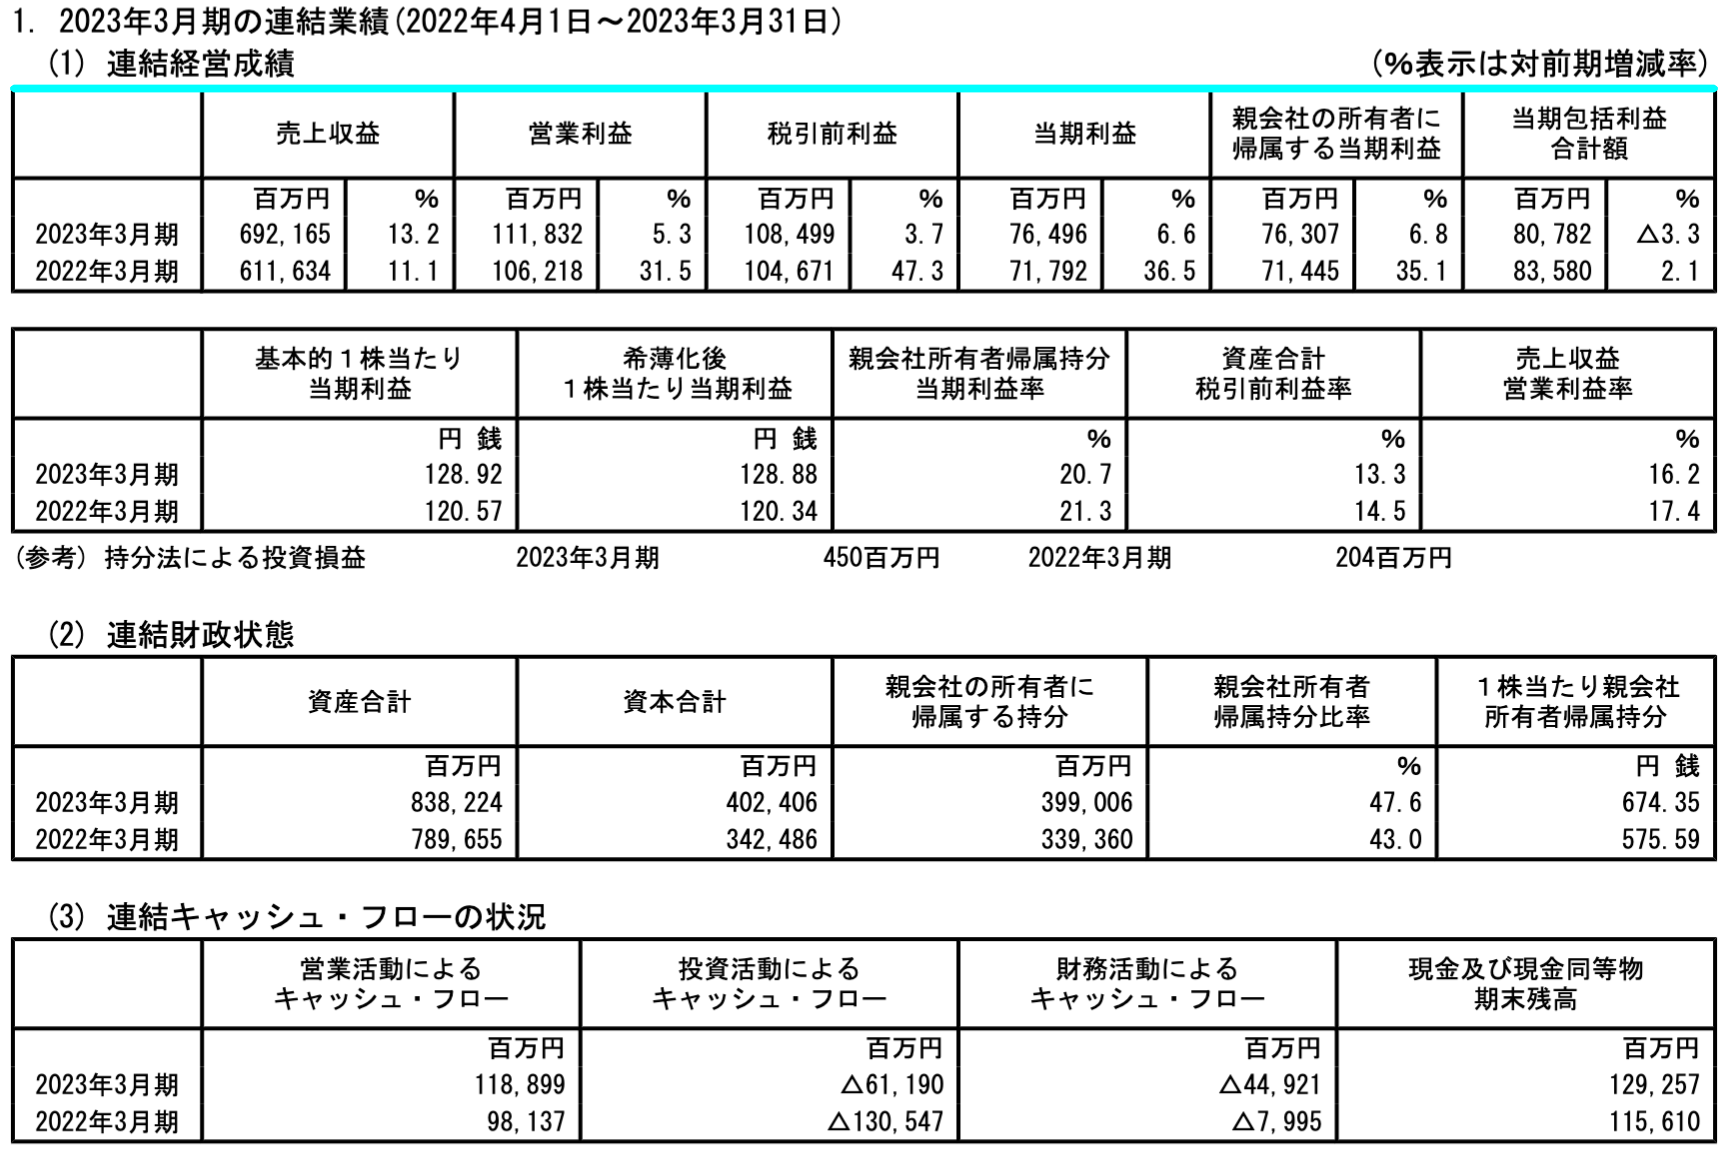

In [152]:
m,a = diff_draw(t_mae_cleansing,t_ato_cleansing,mae_img,ato_img)
PILImage.fromarray(a)